## **JailBreaking Deep Models**

Deep neural networks are vulnerable to adversarial examples—subtle input perturbations that mislead models without noticeable visual changes. This project evaluates the robustness of a pretrained ResNet-34 against FGSM, Iterative FGSM, and localized patch attacks. We also test the transferability of these attacks on DenseNet-121. The results reveal significant performance drops in ResNet-34, while DenseNet shows greater resilience. We conclude with insights into attack effectiveness, model susceptibility, and potential defenses.

## Task1: Basics

In [1]:
#import necessary modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

In [2]:
# Loading pretrained Resnet34 model
pretrained_model = torchvision.models.resnet34(pretrained=True)
pretrained_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 139MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]
        filename = Path(path).stem
        return image, label, filename

In [5]:
# Preprocess the images

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms,
                            std=std_norms)
])

# Extract the TestDataSet
with zipfile.ZipFile('/content/TestDataSet.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/TestDataSet')

root_path = Path("/content/")
dataset_path = root_path / "TestDataSet/TestDataSet"
dataset = ImageFolderWithPaths(root=dataset_path,
                                            transform=plain_transforms)

def update_labels(dataset):
    # Add 401 to the labels of images
    for i in range(len(dataset)):
        dataset.samples[i] = (dataset.samples[i][0], dataset.samples[i][1] + 401)

update_labels(dataset)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

In [6]:
dataset[0]

(tensor([[[-1.2617, -0.7993, -0.7822,  ...,  0.1254, -0.4054, -0.2856],
          [-1.1589, -1.0048, -0.7479,  ...,  0.2796, -0.3712, -0.4226],
          [-0.9363, -1.1075, -0.7993,  ...,  0.0741, -0.5424, -0.6452],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -0.0287, -0.6623, -0.7137],
          [-2.0837, -2.0837, -2.0837,  ..., -0.8507, -0.7993, -0.3541],
          [-2.0837, -2.0837, -2.0837,  ..., -0.3027, -0.2856,  0.0912]],
 
         [[-1.2479, -0.7752, -0.7752,  ...,  0.2227, -0.3200, -0.1975],
          [-1.1429, -0.9853, -0.7402,  ...,  0.3803, -0.2850, -0.3375],
          [-0.9153, -1.0903, -0.7752,  ...,  0.1352, -0.4951, -0.6001],
          ...,
          [-1.9657, -1.9657, -1.9657,  ...,  0.2227, -0.4251, -0.4776],
          [-1.9657, -1.9657, -1.9657,  ..., -0.6176, -0.5651, -0.1099],
          [-1.9657, -1.9657, -1.9657,  ..., -0.0574, -0.0399,  0.3452]],
 
         [[-1.4036, -0.9330, -0.9330,  ...,  0.2348, -0.3055, -0.1835],
          [-1.2990, -1.1421,

In [7]:
label_filepath = dataset_path / 'labels_list.json'

with open(label_filepath) as f:
    label_list = json.load(f)

# Make mappings using the label file given
label_mapping = {}

for i in range(len(label_list)):
    s = label_list[i].split()
    label_mapping[int(s[0][:-1])] = s[1]

In [8]:
# Evaluate the model
def eval_model(model, dataloader, device):
    model.eval()

    top1_correct = 0
    top5_correct = 0

    total = len(dataset)

    with torch.no_grad():
        for images, labels, filenames in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            top1_correct += (predicted == labels).sum().item()

            _, top5_predicted = torch.topk(outputs, 5)
            top5_correct += (top5_predicted == labels.unsqueeze(1)).sum().item()

    #Calculate accuracy
    top1_accuracy = top1_correct / total
    top5_accuracy = top5_correct / total

    return top1_accuracy, top5_accuracy


In [9]:
# Visualize images
def sorted_images(filepath, extension):
    images_filepath = filepath.glob(f"**/*{extension}")
    images_filepath = list(images_filepath)
    images_filepath = sorted(images_filepath, key=lambda path: path.stem)
    return images_filepath

def visualize_images(image_paths, title, random_indices, model, label_mapping):
    fig, axes = plt.subplots(1, len(random_indices), figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image = Image.open(image_paths[idx])
        #Handle grayscale images
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms to the image
        transformed_image = plain_transforms(image)
        # Get the predicted label
        transformed_image = transformed_image.unsqueeze(0).to(device)
        model.eval()
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)

        axes[i].imshow(image)
        axes[i].axis('off')

        if(predicted.item() in label_mapping):
            label = label_mapping[predicted.item()]
        else:
            label = "Unknown"

        axes[i].set_title(f"{label}")


    fig.suptitle(title, y=0.82)
    plt.show()

# Calculate the L-infinity norm
def calculate_l_inf_norm(original_image, adversarial_image):
    l_inf_norm = torch.max(torch.abs(original_image - adversarial_image))
    return l_inf_norm.item()

def check_l_inf_norm(original_image_paths, adversarial_image_paths, random_indices):
    for i in random_indices:
        original_image = Image.open(original_image_paths[i])
        adversarial_image = Image.open(adversarial_image_paths[i])

        # Handle Grayscale images
        if original_image.mode != 'RGB':
            original_image = original_image.convert('RGB')
        # Apply transforms to the images
        original_image_tensor = plain_transforms(original_image)
        adversarial_image_tensor = plain_transforms(adversarial_image)
        #Print the area where the difference is non zero
        # difference = original_image_tensor - adversarial_image_tensor
        # print(original_image_tensor)
        # print(adversarial_image_tensor)

        # Calculate L-infinity norm
        l_inf_norm = calculate_l_inf_norm(original_image_tensor, adversarial_image_tensor)
        print(f"L-infinity norm for image {i+1}: {l_inf_norm:.4f}")
    return

# Get top 1 and top 5 accuracy
def get_top1_top5_accuracy(model, image_path, transforms, device):
    adversarial_image_dataset = ImageFolderWithPaths(root=image_path, transform=transforms)
    update_labels(adversarial_image_dataset)
    adversarial_dataloader = DataLoader(adversarial_image_dataset, batch_size=32, shuffle=False, num_workers=0)
    top1_accuracy, top5_accuracy = eval_model(model, adversarial_dataloader, device)
    return top1_accuracy, top5_accuracy


In [10]:
# Visualize the noise images
def visualize_noise_images(original_image_paths, adversarial_image_paths, random_indices, mean, std, amplify=10.0):
    fig, axes = plt.subplots(1, len(random_indices), figsize=(12, 4))

    for i, idx in enumerate(random_indices):
        orig_img = Image.open(original_image_paths[idx]).convert("RGB")
        adv_img = Image.open(adversarial_image_paths[idx]).convert("RGB")

        orig_tensor = plain_transforms(orig_img)
        adv_tensor = plain_transforms(adv_img)

        # Compute noise in normalized space
        noise = adv_tensor - orig_tensor
        noise_amplified = noise * amplify

        # Normalize noise for visualization
        noise_vis = (noise_amplified - noise_amplified.min()) / (noise_amplified.max() - noise_amplified.min() + 1e-8)
        noise_vis = torch.clamp(noise_vis, 0, 1)

        # Resize to match original image size
        resize = transforms.Resize((224, 224))
        noise_vis_resized = resize(noise_vis)

        # Show using same axes structure
        axes[i].imshow(transforms.ToPILImage()(noise_vis_resized))
        axes[i].axis('off')
        axes[i].set_title(f"Noise {idx+1}")

    fig.suptitle("Adversarial Noise Visualization", y=0.9)
    plt.tight_layout()
    plt.show()


In [32]:
# Get 5 random images for visualization
num_images = 5
dataset_images_filepath = sorted_images(dataset_path, ".JPEG")
random_indices = np.random.choice(len(dataset_images_filepath), num_images, replace=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

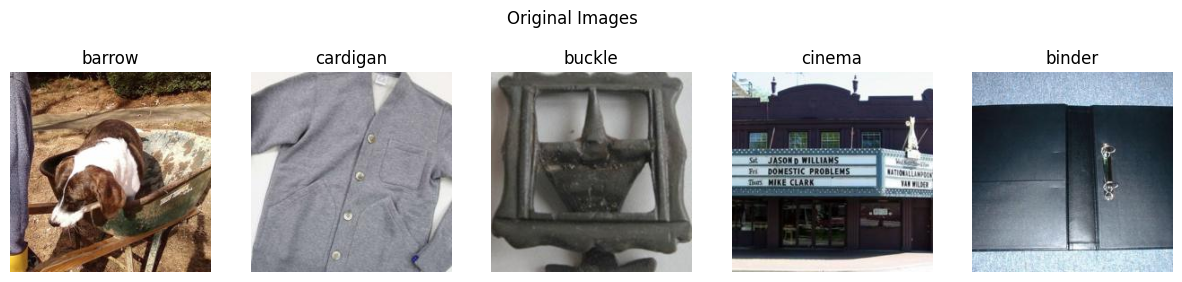

Top-1 Accuracy on original images: 76.00%
Top-5 Accuracy on original images: 94.20%


In [33]:
# Visualize original images
visualize_images(dataset_images_filepath, "Original Images", random_indices, pretrained_model, label_mapping)

# Predict top1, top5 accuracies on the original images
top1_accuracy, top5_accuracy = get_top1_top5_accuracy(pretrained_model, dataset_path, plain_transforms, device)
print(f"Top-1 Accuracy on original images: {top1_accuracy * 100:.2f}%")
print(f"Top-5 Accuracy on original images: {top5_accuracy * 100:.2f}%")

## Task-2: Pixel-Wise Attacks

In [25]:
# Batch denormalize
def denormalize(batch, mean, std):
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    return batch * std[:, None, None] + mean[:, None, None]

In [26]:
# Implement FGSM
epsilon = 0.02

# Using AdversarialTestSet1
fgsm_image_path = root_path / "AdversarialTestSet1"
fgsm_image_path.mkdir(parents=True, exist_ok=True)

# FGSM Attack
def fgsm_attack(model, images, labels, epsilon):
    outputs = model(images)
    model.zero_grad()
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    data_grad = images.grad.data
    perturbed_images = images + epsilon * data_grad.sign() # Attack in the normalized space

    return perturbed_images

# Saving the adversarial images
def save_adversarial_images(model, dataloader, epsilon, image_dir_path, iterations):
    for images, labels, filenames in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = images.clone()

        for i in range(iterations):
            perturbed_images = perturbed_images.clone().detach().requires_grad_(True)
            perturbed_images = fgsm_attack(model, perturbed_images, labels, epsilon / iterations)
        # perturbed_images = fgsm_attack(model, images, labels, epsilon)


        for i in range(len(perturbed_images)):
            unique_image_name = filenames[i]
            image_path = image_dir_path / f'{labels[i].item()}/{unique_image_name}.PNG'
            image_path.parent.mkdir(parents=True, exist_ok=True)

            torchvision.utils.save_image(denormalize(perturbed_images[i], mean_norms, std_norms).cpu(), image_path) # Denormalize and save

    return

save_adversarial_images(pretrained_model, dataloader, epsilon, fgsm_image_path, iterations=1)



100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


In [27]:
fsgm_images_filepath = sorted_images(fgsm_image_path, ".PNG")
dataset_images_filepath = sorted_images(dataset_path, ".JPEG")

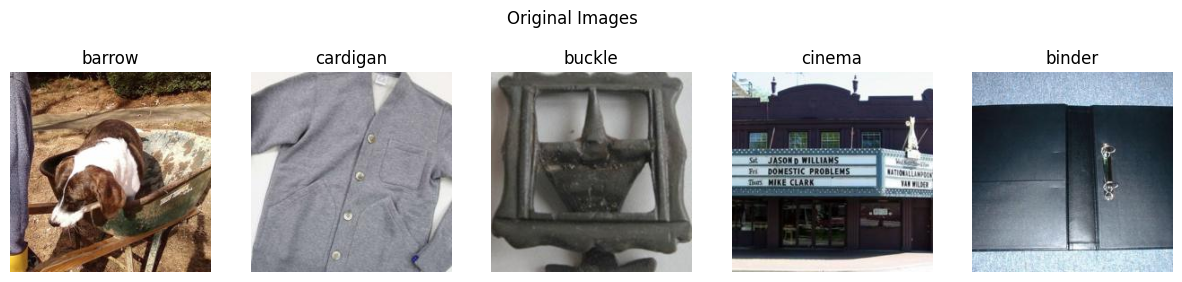

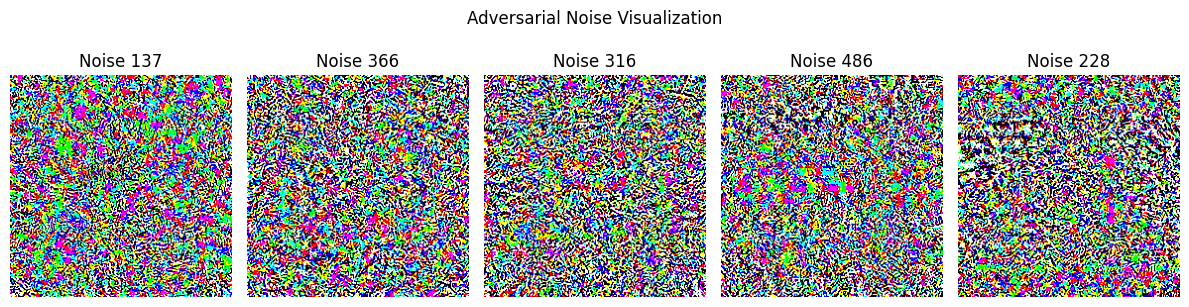

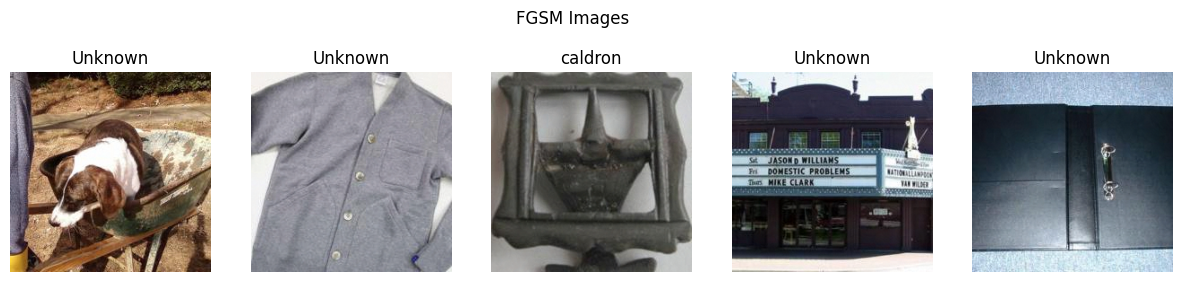

L-infinity norm for image 137: 0.0175
L-infinity norm for image 366: 0.0175
L-infinity norm for image 316: 0.0175
L-infinity norm for image 486: 0.0175
L-infinity norm for image 228: 0.0175
Top-1 Accuracy on Adversarial Images: 7.00%
Top-5 Accuracy on Adversarial Images: 37.40%


In [34]:
# Visualize original images
visualize_images(dataset_images_filepath,'Original Images', random_indices, pretrained_model, label_mapping)

# Visualzie the noise
visualize_noise_images(dataset_images_filepath, fsgm_images_filepath, random_indices, mean=mean_norms, std=std_norms)

# Visualize adversarial images
visualize_images(fsgm_images_filepath, 'FGSM Images', random_indices, pretrained_model, label_mapping)

# Check L-infinity norm for random images
check_l_inf_norm(dataset_images_filepath, fsgm_images_filepath, random_indices)

top1_accuracy_fgsm, top5_accuracy_fgsm = get_top1_top5_accuracy(pretrained_model, fgsm_image_path, plain_transforms, device)

print(f"Top-1 Accuracy on Adversarial Images: {top1_accuracy_fgsm * 100:.2f}%")
print(f"Top-5 Accuracy on Adversarial Images: {top5_accuracy_fgsm * 100:.2f}%")

## Task-3: Improved Attacks - Iterative FGSM

100%|██████████| 16/16 [00:36<00:00,  2.25s/it]


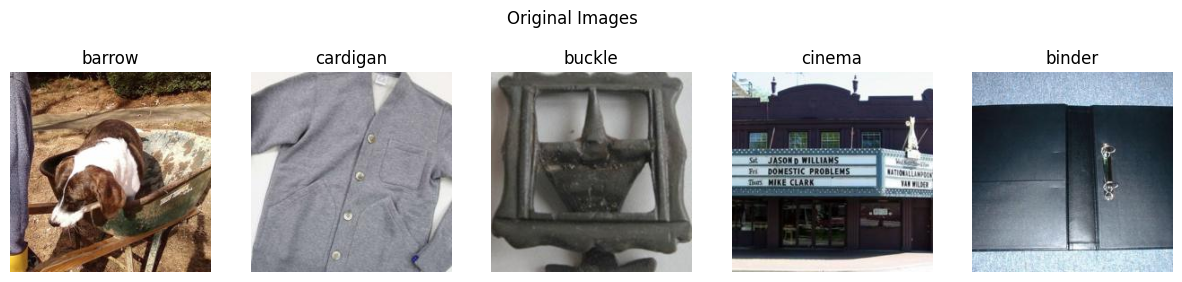

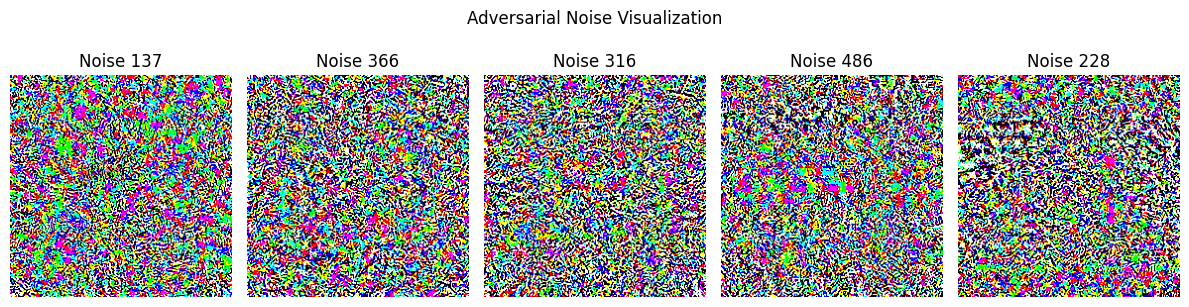

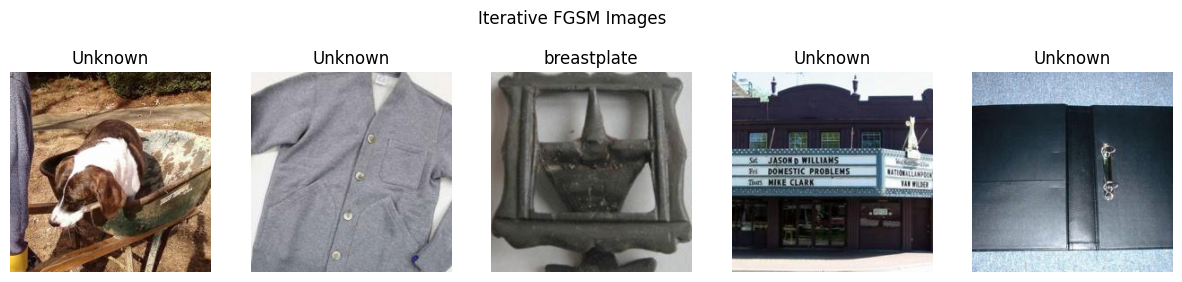

L-infinity norm for image 137: 0.0175
L-infinity norm for image 366: 0.0175
L-infinity norm for image 316: 0.0175
L-infinity norm for image 486: 0.0175
L-infinity norm for image 228: 0.0175
Top-1 Accuracy on Adversarial Images: 0.20%
Top-5 Accuracy on Adversarial Images: 16.80%


In [35]:
# Implement Multiple Gradient step FGSM (Iterative FGSM)
epsilon = 0.02

# Using AdversarialTestSet2
ifgsm_image_path = root_path / "AdversarialTestSet2"
ifgsm_image_path.mkdir(parents=True, exist_ok=True)

save_adversarial_images(pretrained_model, dataloader, epsilon, ifgsm_image_path, iterations=10)

ifgsm_images_filepath = sorted_images(ifgsm_image_path, ".PNG")

# Visualize original images
visualize_images(dataset_images_filepath, 'Original Images', random_indices, pretrained_model, label_mapping)

# Visualzie the noise
visualize_noise_images(dataset_images_filepath, fsgm_images_filepath, random_indices, mean=mean_norms, std=std_norms)

# Visualize adversarial images
visualize_images(ifgsm_images_filepath, 'Iterative FGSM Images', random_indices, pretrained_model, label_mapping)

# Check L-infinity norm for random images
check_l_inf_norm(dataset_images_filepath, ifgsm_images_filepath, random_indices)

# Get top-1 and top-5 accuracy for iterative FGSM
top1_accuracy_ifgsm, top5_accuracy_ifgsm = get_top1_top5_accuracy(pretrained_model, ifgsm_image_path, plain_transforms, device)
print(f"Top-1 Accuracy on Adversarial Images: {top1_accuracy_ifgsm * 100:.2f}%")
print(f"Top-5 Accuracy on Adversarial Images: {top5_accuracy_ifgsm * 100:.2f}%")



## Task 4: Patch attacks

In [36]:
def save_patch_attack_images(model, dataloader, epsilon, patch_size, image_dir_path, iterations=1):
    flag = 0
    for images, labels, filenames in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        random_patch_start_x = torch.randint(0, images.shape[2] - patch_size, (1,))
        random_patch_start_y = torch.randint(0, images.shape[3] - patch_size, (1,))

        perturbed_images = images.clone()
        for i in range(iterations):
            perturbed_images = perturbed_images.clone().detach().requires_grad_(True)
            perturbed_images = fgsm_attack(model, perturbed_images, labels, epsilon / iterations)


            patch = perturbed_images[:, :, random_patch_start_x:random_patch_start_x + patch_size, random_patch_start_y:random_patch_start_y + patch_size]
            perturbed_images = images.clone()
            perturbed_images[:, :, random_patch_start_x:random_patch_start_x + patch_size, random_patch_start_y:random_patch_start_y + patch_size] = patch

        #Calculate the L-inf norm of 5 random iamges in of the first batch
        if(flag == 0):
            r_indices = np.random.choice(len(images), 5, replace=False)
            for i in r_indices:
                original_image = images[i]
                adversarial_image = perturbed_images[i]
                l_inf_norm = calculate_l_inf_norm(original_image, adversarial_image)
                print(f"L-infinity norm for image {i+1}: {l_inf_norm:.4f}")
            flag = 1

        for i in range(len(perturbed_images)):
            # final_perturbed_image = images[i].clone()
            # final_perturbed_image[:, random_patch_start_x:random_patch_start_x + patch_size, random_patch_start_y:random_patch_start_y + patch_size] = perturbed_images[i][:, random_patch_start_x:random_patch_start_x + patch_size, random_patch_start_y:random_patch_start_y + patch_size]
            unique_image_name = filenames[i]
            image_path = image_dir_path / f'{labels[i].item()}/{unique_image_name}.PNG'
            image_path.parent.mkdir(parents=True, exist_ok=True)
            torchvision.utils.save_image(denormalize(perturbed_images[i], mean_norms, std_norms).cpu(), image_path)

    return

  0%|          | 0/16 [00:00<?, ?it/s]

L-infinity norm for image 22: 0.5000
L-infinity norm for image 16: 0.5000
L-infinity norm for image 31: 0.5000
L-infinity norm for image 18: 0.4833
L-infinity norm for image 26: 0.5000


100%|██████████| 16/16 [02:32<00:00,  9.50s/it]


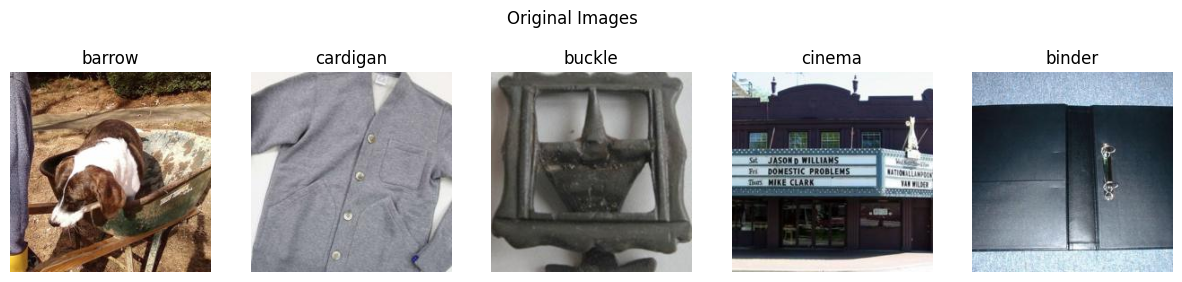

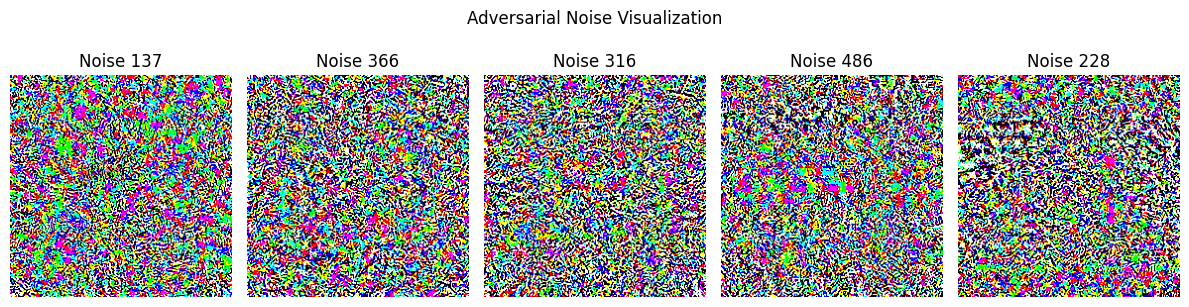

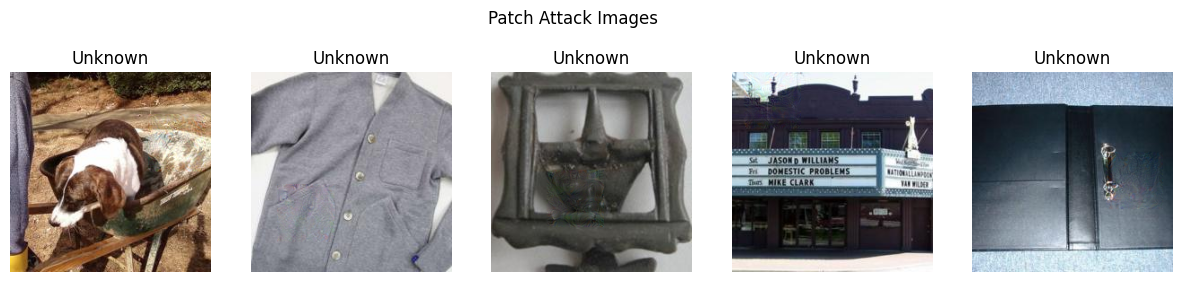

Top-1 Accuracy on Adversarial Images: 2.40%
Top-5 Accuracy on Adversarial Images: 40.60%


In [37]:
epsilon = 0.5
patch_size = 64

# Using AdversarialTestSet3
patch_attack_image_path = root_path / "AdversarialTestSet3"
patch_attack_image_path.mkdir(parents=True, exist_ok=True)

save_patch_attack_images(pretrained_model, dataloader, epsilon, patch_size, patch_attack_image_path, iterations=60)

patch_attack_images_filepath = sorted_images(patch_attack_image_path, ".PNG")

# Visualize original images
visualize_images(dataset_images_filepath, 'Original Images', random_indices, pretrained_model, label_mapping)

# Visualzie the noise
visualize_noise_images(dataset_images_filepath, fsgm_images_filepath, random_indices, mean=mean_norms, std=std_norms)

# Visualize adversarial images
visualize_images(patch_attack_images_filepath, 'Patch Attack Images', random_indices, pretrained_model, label_mapping)

# Get top-1 and top-5 accuracy for patch attack
top1_accuracy_patch, top5_accuracy_patch = get_top1_top5_accuracy(pretrained_model, patch_attack_image_path, plain_transforms, device)
print(f"Top-1 Accuracy on Adversarial Images: {top1_accuracy_patch * 100:.2f}%")
print(f"Top-5 Accuracy on Adversarial Images: {top5_accuracy_patch * 100:.2f}%")


## Task 5: Transferring Attacks - DenseNet121

In [38]:
# Using Densenet121 to transfer attacks
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device)

print('Top=1 and Top-5 accuracy with DenseNet121 model')

#Accuracy on original images
top1_accuracy_original_densenet, top5_accuracy_original_densenet = eval_model(new_model, dataloader, device)
print(f"Top-1 Accuracy on Original Images: {top1_accuracy_original_densenet * 100:.2f}%")
print(f"Top-5 Accuracy on Original Images: {top5_accuracy_original_densenet * 100:.2f}%")

#Accuracy on FGSM images
top1_accuracy_fgsm_densenet, top5_accuracy_fgsm_densenet = get_top1_top5_accuracy(new_model, fgsm_image_path, plain_transforms, device)
print(f"Top-1 Accuracy on FGSM Adversarial Images: {top1_accuracy_fgsm_densenet * 100:.2f}%")
print(f"Top-5 Accuracy on FGSM Adversarial Images: {top5_accuracy_fgsm_densenet * 100:.2f}%")

#Accuracy on Iterative FGSM images
top1_accuracy_ifgsm_densenet, top5_accuracy_ifgsm_densenet = get_top1_top5_accuracy(new_model, ifgsm_image_path, plain_transforms, device)
print(f"Top-1 Accuracy on Iterative FGSM Adversarial Images: {top1_accuracy_ifgsm_densenet * 100:.2f}%")
print(f"Top-5 Accuracy on Iterative FGSM Adversarial Images: {top5_accuracy_ifgsm_densenet * 100:.2f}%")

# Accuracy on Patch Attack images
top1_accuracy_patch_densenet, top5_accuracy_patch_densenet = get_top1_top5_accuracy(new_model, patch_attack_image_path, plain_transforms, device)
print(f"Top-1 Accuracy on Patch Attack Adversarial Images: {top1_accuracy_patch_densenet * 100:.2f}%")
print(f"Top-5 Accuracy on Patch Attack Adversarial Images: {top5_accuracy_patch_densenet * 100:.2f}%")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 200MB/s]


Top=1 and Top-5 accuracy with DenseNet121 model
Top-1 Accuracy on Original Images: 74.80%
Top-5 Accuracy on Original Images: 93.60%
Top-1 Accuracy on FGSM Adversarial Images: 65.20%
Top-5 Accuracy on FGSM Adversarial Images: 89.80%
Top-1 Accuracy on Iterative FGSM Adversarial Images: 65.40%
Top-5 Accuracy on Iterative FGSM Adversarial Images: 91.40%
Top-1 Accuracy on Patch Attack Adversarial Images: 67.60%
Top-5 Accuracy on Patch Attack Adversarial Images: 91.40%


### Findings & Observations

- **FGSM** and **Iterative FGSM** degrade ResNet performance, with iterative versions causing more severe drops.
- **Patch attacks** are effective even when localized, especially with multiple iterations and larger patches.
- **Transferability** is limited — adversarial examples generated on ResNet do not degrade DenseNet accuracy to the same extent.

### Lessons Learned

- Iterative and localized attacks are stronger than single-step methods.
- Model architecture significantly affects adversarial vulnerability.
- Perturbations applied in normalized space must be carefully scaled to respect ε bounds.

### Mitigating Transferability

- Use **adversarial training** with multiple attack types.
- Add **input preprocessing** (e.g., resizing, compression).
- Leverage **ensemble models** to reduce single-model attack success.

### Conclusion

Adversarial attacks are highly architecture-dependent. Evaluating across models (like ResNet vs. DenseNet) is essential to understand real-world robustness and transferability.
